https://www.kaggle.com/competitions/brist1d/data 

**Files**  
**activities.txt** - a list of activity names that appear in the activity-X:XX columns  
**sample_submission.csv** - a sample submission file in the correct format  
**test.csv** - the test set  
**train.csv** - the training set

**Columns**  
**train.csv**  
- id - row id consisting of participant number and a count for that participant  
- p_num - participant number  
- time - time of day in the format HH:MM:SS  
- bg-X:XX - blood glucose reading in mmol/L, X:XX(H:MM) time in the past (e.g. bg-2:35, would be the blood glucose reading from 2 hours and 35 minutes before the time value for that row), recorded by the continuous glucose monitor  
- insulin-X:XX - total insulin dose received in units in the last 5 minutes, X:XX(H:MM) time in the past (e.g. insulin-2:35, would be the total insulin dose received between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the insulin pump  
- carbs-X:XX - total carbohydrate value consumed in grammes in the last 5 minutes, X:XX(H:MM) time in the past (e.g. carbs-2:35, would be the total carbohydrate value consumed between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the participant
- hr-X:XX - mean heart rate in beats per minute in the last 5 minutes, X:XX(H:MM) time in the past (e.g. hr-2:35, would be the mean heart rate between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the smartwatch  
- steps-X:XX - total steps walked in the last 5 minutes, X:XX(H:MM) time in the past (e.g. steps-2:35, would be the total steps walked between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the smartwatch  
- cals-X:XX - total calories burnt in the last 5 minutes, X:XX(H:MM) time in the past (e.g. cals-2:35, would be the total calories burned between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), calculated by the smartwatch  
- activity-X:XX - self-declared activity performed in the last 5 minutes, X:XX(H:MM) time in the past (e.g. activity-2:35, would show a string name of the activity performed between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), set on the smartwatch  
- bg+1:00 - blood glucose reading in mmol/L an hour in the future, this is the value you will be predicting **(not provided in test.csv)**

Данные берутся за последний час. Используются все признаки, в датафрейме index_col='id'. 'time' преобразуется в 'hour' и 'minute'. Проводим интерполяцию значений в bg-X:XX.  

Стоит обратить внимание на проблемы у p11 c insulin-X:XX.

Алгоритм HistGradientBoostingRegressor - реализация градиентно-бустированных деревьев. Этот оценщик имеет встроенную поддержку пропущенных значений (NaN) и категориальных данных.  

Обучающие образцы появляются в хронологическом порядке и перекрываются.    
На валидацию: отбираем пациентов p05 и p10 и 30% последних записей остальных пациентов, убираем перекрытие данных и перемешиваем данные внутри групп.     
Создаем class CustomGroupTimeSeriesSplit для организации кросс-валидации для временных рядов с учетом групп.   

HistGradientBoostingRegressor()   

Перекрестная проверка выполняется  
- при cv=CustomGroupTimeSeriesSplit. Результат RMSE:   
- при cv=GroupKFold, где группы формируются по пациентам (p_num), данные предварительно перемешиваются. Результат RMSE: 

In [ ]:
from typing import Sequence

import numpy as np
from sklearn.model_selection import BaseCrossValidator


class CustomGroupTimeSeriesSplit(BaseCrossValidator):
    """Custom class for group-aware time series cross-validator.

    Класс обеспечивает правильную организацию кросс-валидации, принимая во внимание структуру данных, организованных по группам, и характер временных рядов.
    Особенность данного класса заключается в том, что он учитывает различные объемы данных в каждой группе и создает корректные обучающие и валидационные выборки, соблюдая временной порядок данных.

    Attributes:
        n_splits (int): Number of folds for cross-validation.
    """
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, X, y = None, groups = None):
        """Generates pairs of indices for training and validation, maintaining temporal order and group structure.

        Эта функция принимает матрицу признаков `X`, вектор целей `y` и идентификационную колонку групп `groups`,
        и возвращает генераторы кортежей, содержащих индексы обучающего и валидационного наборов.

        Parameters:
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,), default=None
            The target variable for supervised learning problems.

        groups : array-like of shape (n_samples,), default=None
            Group labels for the samples used while splitting the dataset into
            train/test set.

        Yields:
            tuple: 
                - train_indices (ndarray): The training set indices for that split.
                - valid_indices (ndarray): The validation set indices for that split.
        """
        unique_groups = np.unique(groups)
        # Храним длину для каждой группы
        length_group = {}
        
        # Собираем размер каждой группы
        for grp in unique_groups:
            group_indices = np.where(groups == grp)[0]
            length_group[grp] = len(group_indices)

        train_indices = []
        valid_indices = []           
        
        for fold_num in range(1, self.n_splits + 1):

            # Проходим по каждой группе и разделяем её на обучающую и валидационную выборки
            for grp in unique_groups:
                length = length_group.get(grp,)
                chunk_size = length // (self.n_splits + 1)
                remainder = length % (self.n_splits + 1)
                
                # Определяем границы текущего фолда
                lower_bound_valid = fold_num * chunk_size + remainder
                upper_bound_valid = (fold_num + 1) * chunk_size + remainder
                
                # Разделяем индексы на обучающую и валидационную выборки
                train_idx_group = group_indices[:lower_bound_valid] 
                valid_idx_group = group_indices[lower_bound_valid:upper_bound_valid]
                                
                # Сохраняем индексы
                train_indices.append(train_idx_group)
                valid_indices.append(valid_idx_group)
                        
            yield np.concatenate(train_indices), np.concatenate(valid_indices)

            train_indices.clear()
            valid_indices.clear()

    def get_n_splits(self, X = None, y = None, groups = None):
        """Returns the number of splitting iterations in the cross-validator.

        Parameters:
            X (array-like of shape (n_samples, n_features)): Training data (default=None).
            y (array-like of shape (n_samples,)): The target variable (default=None).
            groups (array-like of shape (n_samples,)): Group labels (default=None).

        Returns:
            int: the number of splitting iterations in the cross-validator.
        """
        return self.n_splits


In [80]:
import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight

In [81]:
random_state = 42

In [82]:
def lower_bound_rmse(y_true, y_pred):
    """
    Рассчитывает нижнюю границу среднеквадратической ошибки (Root Mean Square Error),
    учитывая только случаи, когда прогнозы ниже истинных значений.

    Parameters:
    ----------
    y_true : array-like of shape (n_samples,)
        Истинные целевые значения.

    y_pred : array-like of shape (n_samples,)
        Предсказанные целевые значения моделью.

    Returns:
    -------
    float
        Нижняя граница RMSE. Значение равно нулю, если все прогнозы больше или равны истинным значениям.

    Notes:
    -----
    Данная метрика полезна для анализа ситуаций, когда важно минимизировать количество ошибочных прогнозов, 
    приводящих к заниженным оценкам (например, недооценивание спроса в логистике или производстве). Метрика игнорирует 
    ситуации, когда прогноз превышает фактическое значение, сосредотачиваясь исключительно на случаях недопрогнозирования.
    """ 
    
    # Вычисляем минимальную разницу (разница берется только в случае занижения предикта)
    difference = y_true - y_pred
    errors = difference[difference>0]

    if len(errors) == 0:
        return 0.0
        
    # Возводим в квадрат и усредняем
    squared_errors = errors ** 2
    mean_squared_error = squared_errors.mean()
    
    # Возвращаем квадратный корень
    return np.sqrt(mean_squared_error)

# Реализуем собственную метрику
lb_rmse_metric = make_scorer(lower_bound_rmse, greater_is_better=False)

# Теперь lb_rmse_metric можно использовать в GridSearchCV или CrossValidation

In [83]:
csv_file_path = r'./folder/train.csv'
train_data = pd.read_csv(csv_file_path, index_col='id')

C:\Users\olegs\AppData\Local\Temp\ipykernel_31284\2509235616.py:2: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(csv_file_path, index_col='id')


In [84]:
train_data.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


In [85]:
train_data.shape

(177024, 507)

In [86]:
# статистика
train_data.groupby(['p_num']).describe()

bg-5:55                                                   bg-5:50  \
         count      mean       std  min   25%  50%    75%   max    count   
p_num                                                                      
p01       71.0  9.459155  3.217300  4.7  6.20  9.9  12.10  14.6   3896.0   
p02    25482.0  9.309242  2.917305  2.2  7.20  8.8  10.90  22.2  25483.0   
p03    25701.0  8.576223  3.141339  2.2  6.30  7.9  10.40  22.2  25702.0   
p04    24396.0  7.763166  2.249274  2.2  6.20  7.4   9.00  18.4  24396.0   
p05      439.0  8.966515  3.009345  3.2  6.70  8.8  10.85  17.3   2750.0   
p06      108.0  8.815741  2.552593  4.2  6.55  9.1  10.80  13.7   2722.0   
p10    25106.0  6.366976  1.579870  2.2  5.30  6.0   7.10  15.9  25105.0   
p11    23914.0  9.378527  2.880510  2.2  7.30  9.2  11.30  20.8  23920.0   
p12    24553.0  7.862624  2.837006  2.8  6.00  7.2   9.00  22.2  24559.0   

                 ... cals-0:00          bg+1:00                                \
           mean  ...       75%     max    count      mean       std  min  25%   
p_num            ...                                                            
p01    8.884702  ...     10.98   53.00   8459.0  8.888781  4.132187  2.2  5.6   
p02    9.309724  ...      5.40  116.10  25872.0  9.338358  2.926940  2.2  7.2   
p03    8.576134  ...      7.30   65.85  26028.0  8.583080  3.140478  2.2  6.3   
p04    7.762408  ...      6.18   42.51  24686.0  7.761359  2.246061  2.2  6.2   
p05    8.051091  ...      6.67   45.38   8288.0  8.135582  3.117917  2.2  5.8   
p06    8.717377  ...     13.19   68.03   8383.0  8.936872  3.766780  2.9  6.2   
p10    6.367222  ...     11.99   71.77  25454.0  6.372932  1.576365  2.2  5.3   
p11    9.378190  ...      7.62   66.39  24555.0  9.380721  2.887730  2.2  7.3   
p12    7.862828  ...     20.69   57.88  25299.0  7.847757  2.830094  2.8  6.0   

                        
       50%   75%   max  
p_num                   
p01    8.1  11.5  27.8  
p02    8.8  11.0  22.2  
p03    7.9  10.4  22.2  
p04    7.4   9.0  18.4  
p05    7.8  10.1  22.2  
p06    8.1  10.8  27.8  
p10    6.0   7.2  15.9  
p11    9.3  11.3  21.6  
p12    7.2   9.0  22.2  

[9 rows x 3464 columns]

In [87]:
# имеются ли дубликаты?
train_data.duplicated().sum()

np.int64(0)

In [88]:
# список признаков
list_columns = ['bg', 'insulin', 'carbs', 'hr', 'steps', 'cals', 'activity']

In [89]:
def data_interpolate_hour(data=train_data):
    """
    Функция осуществляет линейную интерполяцию значений временных рядов внутри DataFrame по столбцам bg-X:XX,
    округляя значения до двух знаков после запятой, и очистку данных путем удаления определённых временных интервалов из датасета.

    Функция последовательно проходит по списку колонок и удаляет интервалы времени указанного формата.
    Предполагается, что название колонок содержит часовой диапазон вида "{название}_HH:MM".

    Parameters:
    -----------
    data : pandas.DataFrame, default=train_data
        Входной датасет, содержащий столбцы с именами, включающими часовой диапазон вида "{колонка}-HH:MM".
        Предполагается наличие временной шкалы с регулярностью по минутам.

    Returns:
    --------
    cleaned_df : pandas.DataFrame
        Преобразованный датасет с интерполированными значениями и очищенный от ненужных интервалов.

    Notes:
    ------
    - Колонки, содержащие имена с диапазоном "-5:55" до "-1:00", будут удалены.
    - Функция ожидает, что список `list_columns` содержит названия колонок, для которых выполняется удаление временных интервалов.

    Example:
    --------
    >>> cleaned_data = data_interpolate_hour(train_data)
    """
    df = data.copy()
    df.loc[:,'bg-1:10':'bg-0:00'] = df.loc[:,'bg-1:10':'bg-0:00'].interpolate(axis=1).round(1)
    for _ in list_columns:
        df = df.drop(train_data.loc[:,'{}-5:55'.format(_):'{}-1:00'.format(_)], axis=1)
    return df

In [90]:
train_data_hour = data_interpolate_hour()

In [91]:
df_hour = train_data_hour.copy()
df_hour['time'] = pd.to_timedelta(df_hour['time'])
df_hour

,p_num,time,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,0 days 06:10:00,17.4,17.4,17.5,17.4,17.4,17.3,16.9,16.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,0 days 06:25:00,17.4,17.4,17.3,16.9,16.6,16.2,15.8,15.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,0 days 06:40:00,16.9,16.6,16.2,15.8,15.5,15.1,14.9,14.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,0 days 06:55:00,15.8,15.5,15.1,14.9,14.6,14.4,14.2,14.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,0 days 07:10:00,14.9,14.6,14.4,14.2,14.1,13.9,13.9,13.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p12_25294,p12,0 days 23:35:00,6.3,6.5,6.9,7.5,7.9,8.2,8.7,8.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1
p12_25295,p12,0 days 23:40:00,6.5,6.9,7.5,7.9,8.2,8.7,8.6,8.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9
p12_25296,p12,0 days 23:45:00,6.9,7.5,7.9,8.2,8.7,8.6,8.9,9.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7


In [92]:
df_hour['step'] = df_hour.groupby('p_num').time.diff()
df_hour.groupby('p_num').step.describe()

,count,mean,std,min,25%,50%,75%,max
p_num,,,,,,,,
p01,8458,0 days 00:00:07.519508157,0 days 02:26:02.999072485,-1 days +00:15:00,0 days 00:15:00,0 days 00:15:00,0 days 00:15:00,0 days 04:00:00
p02,25871,0 days 00:00:02.481543040,0 days 01:24:19.153452521,-1 days +00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 03:05:00
p03,26027,0 days 00:00:02.466669228,0 days 01:24:42.714288652,-1 days +00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 04:45:00
p04,24685,0 days 00:00:02.600769698,0 days 01:24:48.155819938,-1 days +00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 03:40:00
p05,8287,0 days 00:00:07.710872450,0 days 02:25:11.880777177,-1 days +00:15:00,0 days 00:15:00,0 days 00:15:00,0 days 00:15:00,0 days 04:05:00
p06,8382,0 days 00:00:05.798138869,0 days 02:28:05.027996162,-1 days +00:15:00,0 days 00:15:00,0 days 00:15:00,0 days 00:15:00,0 days 17:50:00
p10,25453,0 days 00:00:02.003693081,0 days 01:24:53.684855302,-1 days +00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 05:00:00
p11,24554,0 days 00:00:02.614645271,0 days 01:24:36.012332434,-1 days +00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 06:30:00
p12,25298,0 days 00:00:01.921100482,0 days 01:25:45.643076473,-1 days +00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 00:05:00,0 days 15:45:00


In [93]:
df_hour[df_hour.step == np.timedelta64(15, 'm')].groupby('p_num').step.count()

p_num
p01    8143
p02       1
p04       4
p05    8013
p06    8137
p11       1
Name: step, dtype: int64

In [94]:
df_hour[df_hour.step == np.timedelta64(5, 'm')].groupby('p_num').step.count()

p_num
p02    25769
p03    25923
p04    24553
p10    25343
p11    24456
p12    25193
Name: step, dtype: int64

In [95]:
# определяем список активностей
with open(r'./folder/activities.txt', 'r') as file:
    activities = [line[:-1] for line in file]
activities

['Indoor climbing',
 'Run',
 'Strength training',
 'Swim',
 'Bike',
 'Dancing',
 'Stairclimber',
 'Spinning',
 'Walking',
 'HIIT',
 'Outdoor Bike',
 'Walk',
 'Aerobic Workout',
 'Tennis',
 'Workout',
 'Hike',
 'Zumba',
 'Sport',
 'Yoga',
 'Swimming',
 'Weights',
 'Running']

In [96]:
cat_dtype = CategoricalDtype(categories=activities, ordered=False)

In [97]:
number_of_elements = train_data_hour.size  # Количество элементов в датасете
train_len = train_data_hour.shape[0]  # Всего записей (строк) в датасете

number_missing_values_in_column = train_data_hour.isnull().sum()  # Количество NaN в колонке
number_missing_values = number_missing_values_in_column.sum()  # Количество всех NaN

print(f"Всего записей: {train_len}, всего значений: {number_of_elements}")
print(f"Пропущенных значений: {number_missing_values}, {round(((number_missing_values / number_of_elements) * 100), 2)} %")

percentage = train_data_hour.isnull().mean() * 100
missing = pd.DataFrame({"Кол-во пропущенных значений": number_missing_values_in_column, 
                        "Процент пропусков": round(percentage, 2)}).sort_values("Процент пропусков")
missing

Всего записей: 177024, всего значений: 15401088
Пропущенных значений: 6492451, 42.16 %


,Кол-во пропущенных значений,Процент пропусков
p_num,0,0.00
time,0,0.00
bg+1:00,0,0.00
bg-0:00,773,0.44
bg-0:05,896,0.51
...,...,...
carbs-0:35,174467,98.56
carbs-0:10,174481,98.56
carbs-0:25,174487,98.57
carbs-0:40,174488,98.57


In [98]:
csv_file_path = r'./folder/test.csv'
test_data = pd.read_csv(csv_file_path, index_col='id')
test_data.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
test_data.groupby(['p_num']).count()

,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
p_num,,,,,,,,,,,,,,,,,,,,,
p01,244,2,96,146,1,94,146,1,95,148,...,5,4,5,4,4,4,4,4,5,3
p02,227,222,222,222,222,222,221,221,221,221,...,9,9,9,8,8,8,8,8,7,6
p04,258,256,256,256,256,256,256,256,256,256,...,7,5,6,7,6,6,5,5,5,5
p05,276,4,127,140,5,119,148,5,116,150,...,5,5,3,4,4,5,6,4,5,5
p06,234,3,94,133,3,95,133,2,91,136,...,7,9,12,14,12,11,8,7,6,7
p10,179,175,175,175,175,175,175,174,175,175,...,9,8,10,10,11,11,9,11,13,14
p11,221,217,218,218,218,218,218,217,217,217,...,4,4,4,3,2,2,1,1,1,1
p12,288,282,282,281,281,281,281,282,282,282,...,1,1,2,3,3,3,2,2,2,1
p15,294,291,292,292,291,290,291,291,291,291,...,0,0,0,0,0,0,0,0,0,0


In [100]:
test_data_hour = data_interpolate_hour(test_data)

In [101]:
number_of_elements = test_data_hour.size  # Количество элементов в датасете
test_len = test_data_hour.shape[0]  # Всего записей (строк) в датасете

number_missing_values_in_column = test_data_hour.isnull().sum()  # Количество NaN в колонке
number_missing_values = number_missing_values_in_column.sum()  # Количество всех NaN

print(f"test \nВсего записей: {test_len}, всего значений: {number_of_elements}")
print(f"Пропущенных значений: {number_missing_values}, {round(((number_missing_values / number_of_elements) * 100), 2)} %")

percentage = test_data_hour.isnull().mean() * 100
missing = pd.DataFrame({"Кол-во пропущенных значений": number_missing_values_in_column, "Процент пропусков": round(percentage, 2)}).sort_values("Процент пропусков")
missing

test 
Всего записей: 3644, всего значений: 313384
Пропущенных значений: 135108, 43.11 %


,Кол-во пропущенных значений,Процент пропусков
p_num,0,0.00
time,0,0.00
bg-0:00,56,1.54
bg-0:05,66,1.81
bg-0:10,71,1.95
...,...,...
activity-0:40,3582,98.30
activity-0:00,3583,98.33
activity-0:25,3583,98.33
activity-0:10,3586,98.41


In [102]:
def transformation_ds(data=train_data_hour):
  """
    Трансформирует исходный датасет, извлекая временные признаки и преобразуя категориальные переменные.

    Эта функция принимает датасет, содержащий временную колонку ('time') формата '%H:%M:%S'.
    Она добавляет дополнительные признаки (часы и минуты), удаляет исходную временную колонку,
    конвертирует категориальные столбцы в category тип данных.

    Parameters:
    -----------
    data : DataFrame, default=train_data_hour
        Исходный датасет, содержащий хотя бы один столбец 'time' формата '%H:%M:%S'. По умолчанию передается глобальная переменная train_data_hour.

    Returns:
    --------
    transformed_X : DataFrame
        Преобразованный датасет с извлеченными признаками часов и минут, исключенной колонкой 'time',
        обработанными пропусками и приведением типов данных категорий.

    Example:
    --------
    >>> transformed_df = transformation_ds(train_data_hour)
  """
  X = data.copy()
  # Переводим колонку 'time' to datetime and extract features
  X['time'] = pd.to_datetime(X['time'], format='%H:%M:%S')
  # Выводим часы и минуты как числовые данные
  X['hour'] = X['time'].dt.hour
  X['minute'] = X['time'].dt.minute
  # Удаляем колонку 'time'
  X.drop('time', axis=1, inplace=True)
  X['p_num'] = X['p_num'].astype('category')
  activity_columns = X.select_dtypes(include=['object']).columns
  X[activity_columns] = X[activity_columns].astype(cat_dtype)
  return X

In [103]:
X = transformation_ds(train_data_hour)
y = X.pop('bg+1:00')

In [104]:
# отбираем пациентов для валидации
# p05 (временной шаг 15 мин, имеется разность между временными отметками 10 мин (27 записей), 20 мин (118 записей) и более (38 записей)) - аналог пациенты p01, p06
# и p10 (временной шаг 5 мин, имеется разность между временными отметками 10 мин (10 записей) и более 15 мин (11 записей)) - аналог пациенты p02, p03, p04, p06, p11, p12
data_p05_10 = train_data_hour[train_data_hour['p_num'].isin(['p05','p10'])]

# данные по остальным пациентам
data_p_other = train_data_hour.drop(data_p05_10.index)
# сгруппированные данные по остальным пациентам
data_group_other = data_p_other.groupby(['p_num'], sort=False, observed=False)

# процент данных по остальным пациентам, идущих в обучающий набор
train_ratio = 0.7

# количество данных по каждому из оставшихся пациентов, идущих в обучающий набор
train_data_other_groupcount = (data_group_other['time'].count() * train_ratio).astype(int)

# отбор данных по каждому из оставшихся пациентоа в валидационный набор
X_train = data_group_other.apply(lambda x: x.head(train_data_other_groupcount[x.name]), include_groups=False).reset_index(level=0) # обучающая выборка

X_valid_intersections = train_data_hour.drop(X_train.index)
# убираем перекрытия данных
data_p01_05_06_no_intersections = X_valid_intersections[X_valid_intersections['p_num'].isin(['p01','p05','p06'])][::4]
data_group_other_no_intersections = X_valid_intersections[~X_valid_intersections['p_num'].isin(['p01','p05','p06'])][::12]
X_valid = pd.concat([data_p01_05_06_no_intersections, data_group_other_no_intersections])
# перемешиваем внутри групп
X_valid = X_valid.groupby('p_num').sample(frac=1) # валидационная выборка с перемешиванием
 
# сбрасываем индексы ?????
#X_train = X_train.reset_index(drop=True)
#X_valid = X_valid.reset_index(drop=True)

In [105]:
print(f'Количество данных в валидационной выборке: {X_valid.shape[0]},\n' \
f'Количество данных в обучающей выборке: {X_train.shape[0]},\n' \
f'Количество исходных данных: {train_len},\n' \
f'Поцент данных в обучающей выборке от общего количества: {round(X_train.shape[0] / train_len * 100, 1)} %,\n' \
f'Поцент данных в валидационной выборке от общего количества в обучающей и валидационной выборке: {round(X_valid.shape[0] / (X_valid.shape[0] + X_train.shape[0]) * 100, 1)} %')

Количество данных в валидационной выборке: 8619,
Количество данных в обучающей выборке: 100295,
Количество исходных данных: 177024,
Поцент данных в обучающей выборке от общего количества: 56.7 %,
Поцент данных в валидационной выборке от общего количества в обучающей и валидационной выборке: 7.9 %


In [106]:
# количество данных в валидационной выборке
X_valid.groupby(['p_num'])['time'].count()

p_num
p01     635
p02     647
p03     651
p04     617
p05    2072
p06     629
p10    2121
p11     614
p12     633
Name: time, dtype: int64

In [107]:
# Присваиваем признаки и метку
y_train = X_train.pop('bg+1:00')
y_valid = X_valid.pop('bg+1:00')
X_train = transformation_ds(X_train)
X_valid = transformation_ds(X_valid)

In [108]:
y_train.isna().sum()

np.int64(0)

In [109]:
rng = np.random.RandomState(random_state)
hgbr_model = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    loss="squared_error",
    learning_rate=0.01,
    max_iter=500,
    max_leaf_nodes=70,
    min_samples_leaf=80,
    l2_regularization=1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=rng
)
p_weights = compute_sample_weight(class_weight="balanced", y=X_train.p_num)
hgbr_model.fit(X_train, y_train, sample_weight=p_weights)

root_mean_squared_error(y_valid, hgbr_model.predict(X_valid)), lower_bound_rmse(y_valid, hgbr_model.predict(X_valid))

(2.010053271736819, np.float64(2.2226534113995977))

In [29]:
# модель для прогнозирования уровня глюкозы для пациентов, входящих в набор данных
from sklearn.utils.class_weight import compute_sample_weight
rng = np.random.RandomState(random_state)
estimator_hgbr = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=0.01, 
    max_iter=500, 
    n_iter_no_change=20, 
    early_stopping=True, 
    random_state=rng
    )
hyperparameter_grid = {'l2_regularization': [1, 2, 3, 4], 
                       'max_leaf_nodes': np.arange(60, 100, 10), 
                       'min_samples_leaf': np.arange(60, 100, 10), 
                       }
custom_cv = CustomGroupTimeSeriesSplit()

# Настройка Grid Search
grid_search = GridSearchCV(
    estimator=estimator_hgbr,
    param_grid=hyperparameter_grid,
    scoring='neg_root_mean_squared_error', # Использование отрицательного RMSE
    cv=custom_cv,
    n_jobs=-1
)

# Обучение модели и поиск лучших параметров
p_weights = compute_sample_weight(
    class_weight="balanced", 
    y=X_train.p_num
    )
grid_search.fit(X_train, y_train, groups=X_train.p_num, sample_weight=p_weights)
hgbr_cgtss = grid_search.best_estimator_ # лучшая модель

In [30]:
grid_search.best_estimator_

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=3,
                              learning_rate=0.01, max_iter=500,
                              max_leaf_nodes=np.int64(70),
                              min_samples_leaf=np.int64(70),
                              n_iter_no_change=20,
                              random_state=RandomState(MT19937) at 0x20027B5B540)

In [31]:
grid_search.best_score_

np.float64(-1.5571501545282218)

In [110]:
from sklearn.utils.class_weight import compute_sample_weight
rng = np.random.RandomState(random_state)
hgbr_cgtss = HistGradientBoostingRegressor(early_stopping=True, 
                                           l2_regularization=3,
                                           learning_rate=0.01, max_iter=500,
                                           max_leaf_nodes=np.int64(70),
                                           min_samples_leaf=np.int64(70),
                                           n_iter_no_change=20,
                                           random_state=rng,
                                           )

p_weights = compute_sample_weight(class_weight="balanced", y=X_train.p_num)
hgbr_cgtss.fit(X_train, y_train, sample_weight=p_weights)

root_mean_squared_error(y_valid, hgbr_cgtss.predict(X_valid)), lower_bound_rmse(y_valid, hgbr_cgtss.predict(X_valid))

(2.0111722513177943, np.float64(2.2268862070413236))

In [111]:
custom_cv = CustomGroupTimeSeriesSplit()
results_score = cross_val_score(
    hgbr_cgtss,
    X_train, y_train,
    cv=custom_cv,
    groups=X_train.p_num,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    )
print('Качество модели для прогнозирования уровня глюкозы для пациентов, входящих в набор данных')
-results_score.mean(), results_score.std()

Качество модели для прогнозирования уровня глюкозы для пациентов, входящих в набор данных


(np.float64(1.5694005830674942), np.float64(0.07397847896249875))

In [112]:
root_mean_squared_error(y_valid, hgbr_cgtss.predict(X_valid))

2.0111722513177943

In [113]:
# перекрестная проверка для групп
from sklearn.model_selection import GroupKFold
outer_cv = GroupKFold(n_splits=5)
results_score = cross_val_score(
    hgbr_cgtss,
    X_train, y_train,
    groups=X_train.p_num,
    cv=outer_cv,   
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    )
print('Модель для прогнозирования уровня глюкозы для пациентов, входящих в набор данных:\n' \
'результат перекрестной проверки, где обучение происходит на данных одних пациентов, а проверка на данных других пациентов')
-results_score.mean(), results_score.std()

Модель для прогнозирования уровня глюкозы для пациентов, входящих в набор данных:
результат перекрестной проверки, где обучение происходит на данных одних пациентов, а проверка на данных других пациентов


(np.float64(2.106850979434436), np.float64(0.1776993155234937))

In [114]:
lower_bound_rmse(y_valid, hgbr_cgtss.predict(X_valid))

np.float64(2.2268862070413236)

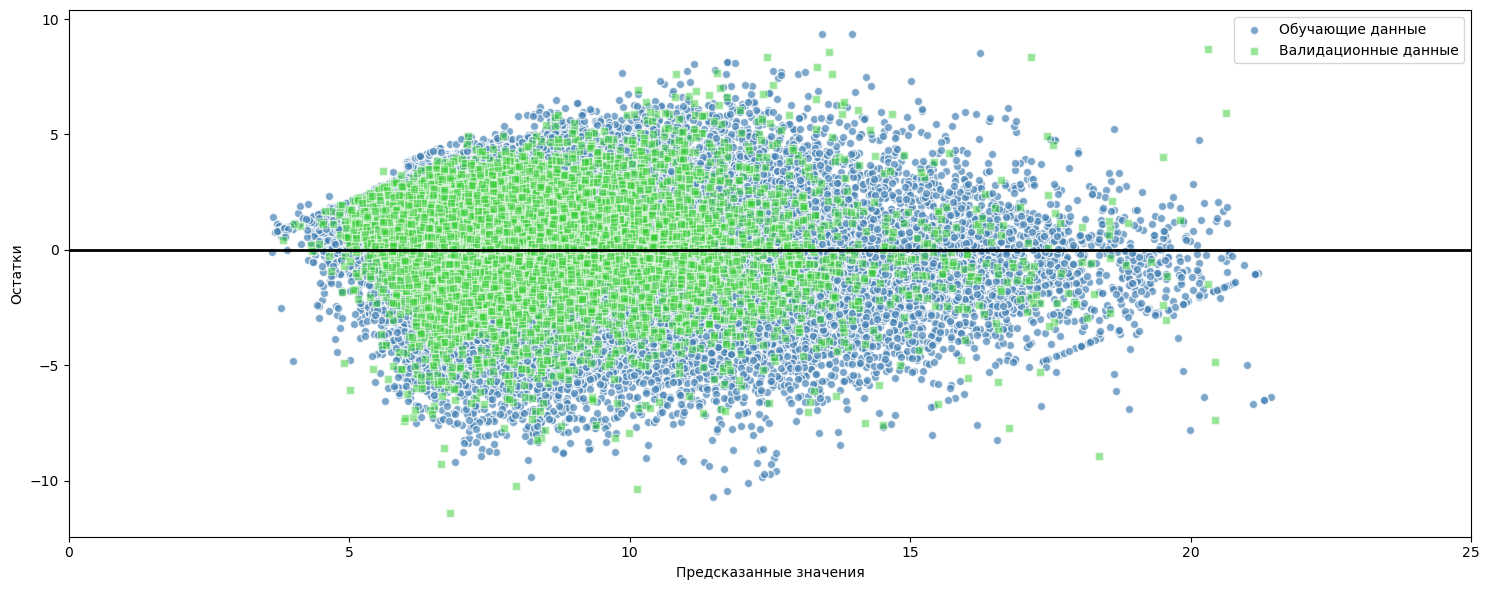

In [115]:
import matplotlib.pyplot as plt


y_train_pred = hgbr_cgtss.predict(X_train)
y_valid_pred = hgbr_cgtss.predict(X_valid)

plt.figure(figsize=(15, 6))
# Для обучающей выборки
plt.scatter(y_train_pred,  # предсказанные значения
            y_train_pred - y_train, # предсказанные значения - истинные значения
            # Настройка (можно оставить без изменений)
            c='steelblue',
            edgecolor='white',
            marker='o',
            #s=35,
            alpha=0.7,
            label='Обучающие данные')

# Для тестовой выборки
plt.scatter(y_valid_pred,  # предсказанные значения
            y_valid_pred - y_valid, # предсказанные значения - истинные значения
            # Настройка (можно оставить без изменений)
            c='limegreen',
            edgecolor='white',
            marker='s',
            #s=35,
            alpha=0.5,
            label='Валидационные данные')

plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend()
plt.hlines(y=0, xmin=0, xmax=25, lw=2, color='black')
plt.xlim([0, 25])
plt.tight_layout()

In [116]:
rng = np.random.RandomState(random_state)
hgbr_estimator = HistGradientBoostingRegressor(
    categorical_features='from_dtype',
    learning_rate=.01,
    max_iter=700, 
    n_iter_no_change=30, 
    early_stopping=True, 
    random_state=rng,
    )
grid_hyperparameter = {'l2_regularization': [1, 3, 5, 7], 
                       'max_leaf_nodes': np.arange(30, 70, 10), 
                       'min_samples_leaf': np.arange(180, 220, 10), 
                       }

kfold_cv = GroupKFold()

# Настройка Grid Search
grid_search_kfold = GridSearchCV(
    estimator=hgbr_estimator,
    param_grid=grid_hyperparameter,
    scoring='neg_root_mean_squared_error', # Использование отрицательного RMSE
    cv=kfold_cv,
    n_jobs=-1
)

p_weights = compute_sample_weight(class_weight="balanced", y=X_train.p_num)
# Обучение модели и поиск лучших параметров
grid_search_kfold.fit(
    X_train, y_train, 
    groups=X_train.p_num, 
    sample_weight=p_weights,
    )
hgbr_GroupKFold = grid_search_kfold.best_estimator_ # лучшая модель

In [117]:
grid_search_kfold.best_estimator_

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=5,
                              learning_rate=0.01, max_iter=700,
                              max_leaf_nodes=np.int64(50),
                              min_samples_leaf=np.int64(200),
                              n_iter_no_change=30,
                              random_state=RandomState(MT19937) at 0x2002813DB40)

In [118]:
grid_search_kfold.best_score_

np.float64(-2.0960997230664273)

In [119]:
rng = np.random.RandomState(random_state)
hgbr_GroupKFold = HistGradientBoostingRegressor(early_stopping=True, 
                                           l2_regularization=5,
                                           learning_rate=0.01, 
                                           max_iter=700,
                                           max_leaf_nodes=np.int64(50),
                                           min_samples_leaf=np.int64(200),
                                           n_iter_no_change=30,
                                           random_state=rng,
                                           )

p_weights = compute_sample_weight(class_weight="balanced", y=X_train.p_num)
hgbr_GroupKFold.fit(X_train, y_train, sample_weight=p_weights)

root_mean_squared_error(y_valid, hgbr_GroupKFold.predict(X_valid)), lower_bound_rmse(y_valid, hgbr_GroupKFold.predict(X_valid))

(2.008816986037551, np.float64(2.2091925379764668))

In [120]:
kfold_cv = GroupKFold()
results_score = cross_val_score(
    hgbr_GroupKFold,
    X_train, y_train,
    cv=kfold_cv,
    groups=X_train.p_num,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    )
results_score.mean(), results_score.std()

(np.float64(-2.1030849729690777), np.float64(0.17556536606203632))

In [121]:
root_mean_squared_error(y_valid, hgbr_GroupKFold.predict(X_valid))

2.008816986037551

In [122]:
results_score = cross_val_score(
    hgbr_GroupKFold,
    X_train, y_train,
    groups=X_train.p_num,
    cv=custom_cv,   
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    )
-results_score.mean(), results_score.std()

(np.float64(1.5615184206329775), np.float64(0.07077051896835056))

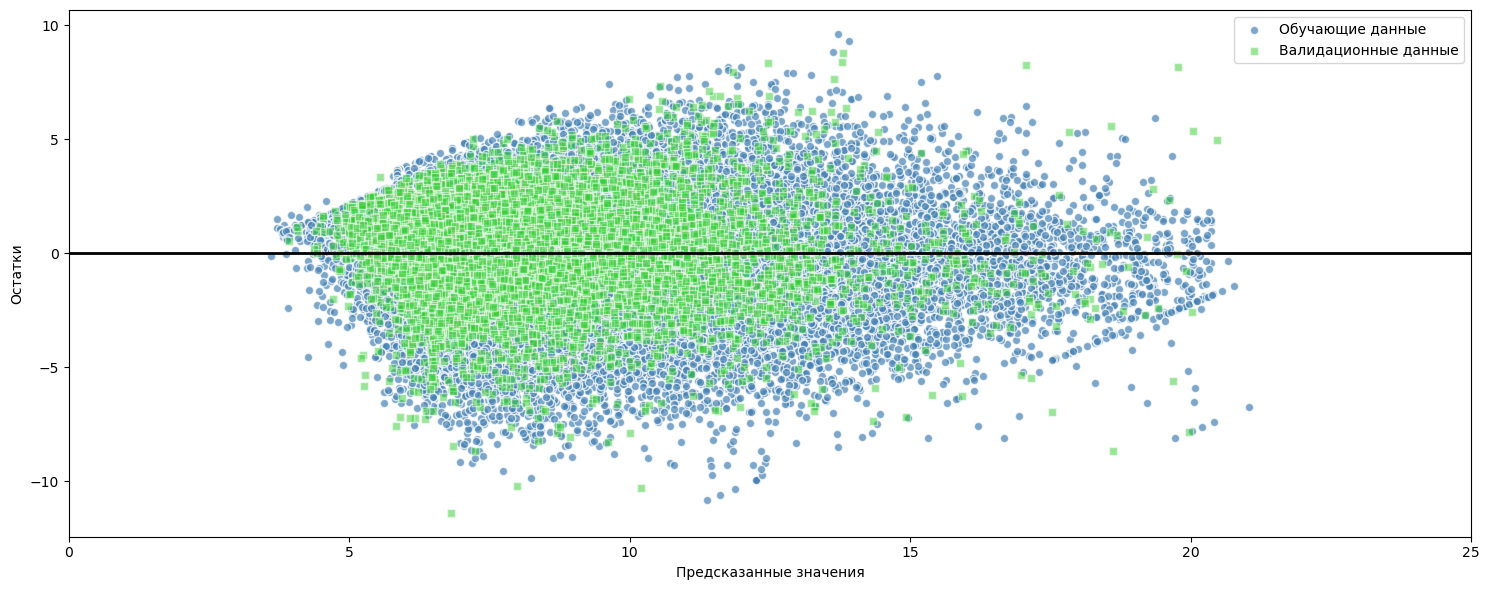

In [123]:
y_train_pred = hgbr_GroupKFold.predict(X_train)
y_valid_pred = hgbr_GroupKFold.predict(X_valid)

plt.figure(figsize=(15, 6))
# Для обучающей выборки
plt.scatter(y_train_pred,  # предсказанные значения
            y_train_pred - y_train, # предсказанные значения - истинные значения
            # Настройка (можно оставить без изменений)
            c='steelblue',
            edgecolor='white',
            marker='o',
            #s=35,
            alpha=0.7,
            label='Обучающие данные')

# Для тестовой выборки
plt.scatter(y_valid_pred,  # предсказанные значения
            y_valid_pred - y_valid, # предсказанные значения - истинные значения
            # Настройка (можно оставить без изменений)
            c='limegreen',
            edgecolor='white',
            marker='s',
            #s=35,
            alpha=0.5,
            label='Валидационные данные')

plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend()
plt.hlines(y=0, xmin=0, xmax=25, lw=2, color='black')
plt.xlim([0, 25])
plt.tight_layout()

In [124]:
p_weights = compute_sample_weight(class_weight="balanced", y=X.p_num)
hgbr_GroupKFold.fit(X, y,sample_weight=p_weights)

HistGradientBoostingRegressor(early_stopping=True, l2_regularization=5,
                              learning_rate=0.01, max_iter=700,
                              max_leaf_nodes=np.int64(50),
                              min_samples_leaf=np.int64(200),
                              n_iter_no_change=30,
                              random_state=RandomState(MT19937) at 0x20028C55040)

In [125]:
root_mean_squared_error(y, hgbr_GroupKFold.predict(X))

1.8220871289515763

In [126]:
test_data_hour = data_interpolate_hour(test_data)
X_test = transformation_ds(test_data_hour)
predictions = hgbr_GroupKFold.predict(X_test)

In [127]:
output = pd.DataFrame({'id': test_data.index, 'bg+1:00': predictions.round(1)})
#output.to_csv('submission_hour_interp.csv', index=False)
#print("Your submission was successfully saved!")

Your submission was successfully saved!


In [128]:
output

,id,bg+1:00
0,p01_8459,8.9
1,p01_8460,5.6
2,p01_8461,8.1
3,p01_8462,10.8
4,p01_8463,6.6
...,...,...
3639,p24_256,6.5
3640,p24_257,10.6
3641,p24_258,6.9
3642,p24_259,8.5


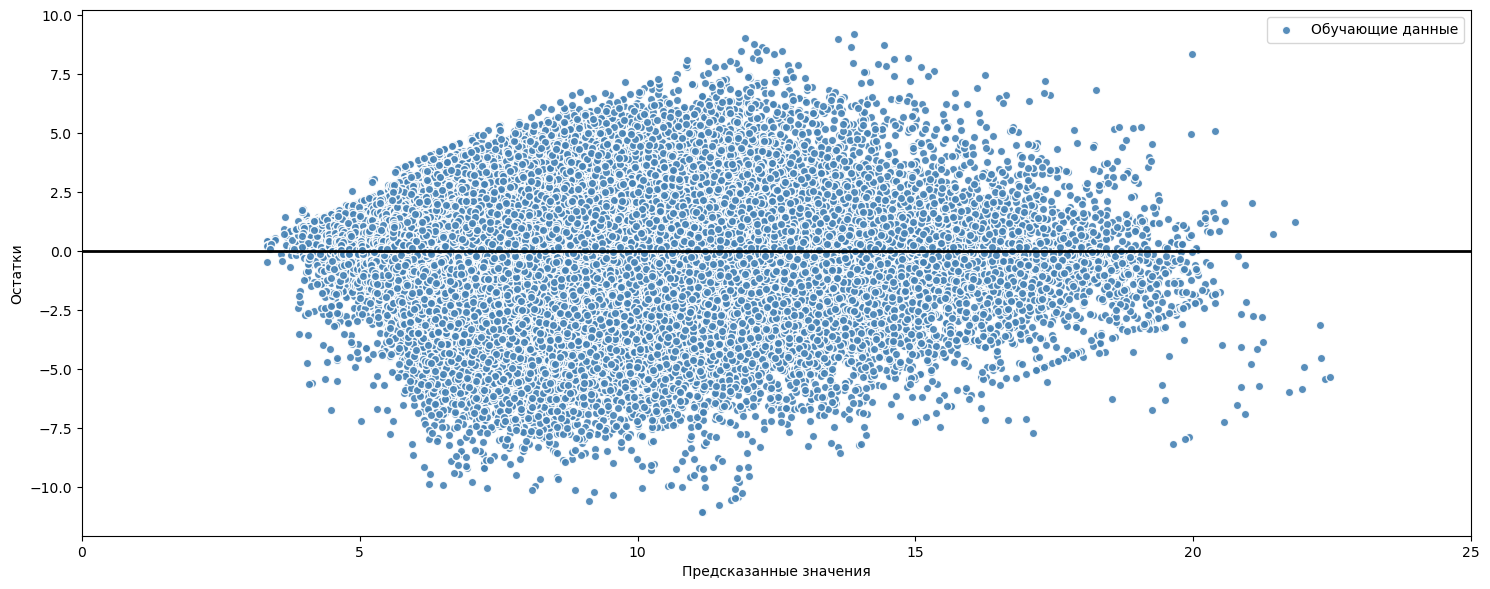

In [129]:
y_pred = hgbr_GroupKFold.predict(X)

plt.figure(figsize=(15, 6))
# Для обучающей выборки
plt.scatter(y_pred,  # предсказанные значения
            y_pred - y, # предсказанные значения - истинные значения
            # Настройка (можно оставить без изменений)
            c='steelblue',
            edgecolor='white',
            marker='o',
            #s=35,
            alpha=0.9,
            label='Обучающие данные')

plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend()
plt.hlines(y=0, xmin=0, xmax=25, lw=2, color='black')
plt.xlim([0, 25])
plt.tight_layout()

In [130]:
from joblib import dump

#dump(hgbr_GroupKFold, 'best_model.joblib')